In [22]:
%matplotlib inline
import pandas as pd
from os.path import join
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import skbio
from stats import mc_t_two_sample
from skbio.stats.distance import anosim, permanova
from skbio.stats.composition import ancom, multiplicative_replacement
import itertools

##Define a couple of helper functions

In [23]:
def get_within_between_distances(map_df, dm, col):
    filtered_dm, filtered_map = filter_dm_and_map(dm, map_df)
    groups = []
    distances = []
    map_dict = filtered_map[col].to_dict()
    for id_1, id_2 in itertools.combinations(filtered_map.index.tolist(), 2):
        row = []
        if map_dict[id_1] == map_dict[id_2]:
            groups.append('Within')
        else:
            groups.append('Between')
        distances.append(filtered_dm[(id_1, id_2)])
    groups = zip(groups, distances)
    distances_df = pd.DataFrame(data=list(groups), columns=['Groups', 'Distance'])

    return distances_df
    
    
def filter_dm_and_map(dm, map_df):
    ids_to_exclude = set(dm.ids) - set(map_df.index.values)
    ids_to_keep = set(dm.ids) - ids_to_exclude
    filtered_dm = dm.filter(ids_to_keep)
    filtered_map = map_df.loc[ids_to_keep]

    return filtered_dm, filtered_map

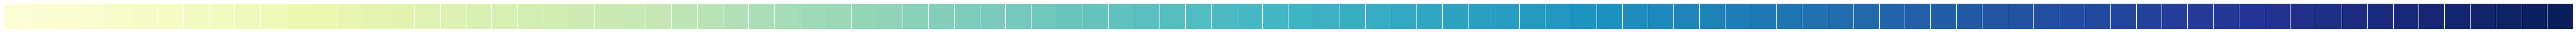

In [24]:
colors = sns.color_palette("YlGnBu", 100)
sns.palplot(colors)

Load mapping file and munge it
-----------------

In [25]:
home = '/home/office-microbe-files'
map_fp = join(home, 'master_map_150908.txt')

In [26]:
sample_md = pd.read_csv(map_fp, sep='\t', index_col=0, dtype=str)
sample_md = sample_md[sample_md['16SITS'] == '16S']
sample_md = sample_md[sample_md['OfficeSample'] == 'yes']

In [27]:
replicate_ids = '''F2F.2.Ce.021
F2F.2.Ce.022
F2F.3.Ce.021
F2F.3.Ce.022
F2W.2.Ca.021
F2W.2.Ca.022
F2W.2.Ce.021
F2W.2.Ce.022
F3W.2.Ce.021
F3W.2.Ce.022
F1F.3.Ca.021
F1F.3.Ca.022
F1C.3.Ca.021
F1C.3.Ca.022
F1W.2.Ce.021
F1W.2.Ce.022
F1W.3.Dr.021
F1W.3.Dr.022
F1C.3.Dr.021
F1C.3.Dr.022
F2W.3.Dr.059
F3F.2.Ce.078'''.split('\n')

In [28]:
reps = sample_md[sample_md['Description'].isin(replicate_ids)]
reps = reps.drop(reps.drop_duplicates('Description').index).index
sample_md.drop(reps, inplace=True)

Load alpha diversity
----------------------

In [29]:
alpha_div_fp = '/home/office-microbe-files/core_div_out/arare_max1000/alpha_div_collated/PD_whole_tree.txt'
alpha_div = pd.read_csv(alpha_div_fp, sep='\t', index_col=0)
alpha_div = alpha_div.T.drop(['sequences per sample', 'iteration'])
alpha_cols = [e for e in alpha_div.columns if '1000' in e]
alpha_div = alpha_div[alpha_cols]

add alpha diversity to map
-------------

In [30]:
sample_md = pd.concat([sample_md, alpha_div], axis=1, join='inner')
sample_md['MeanAlpha'] = sample_md[alpha_cols].mean(axis=1)

Filter the samples so that only corrosponding row 2, 3 samples are included
-----------------------------------------------------------

In [31]:
sample_md['NoRow'] = sample_md['Description'].apply(lambda x: x[:3] + x[5:])
row_df = sample_md[sample_md.duplicated('NoRow', keep=False)].copy()

In [32]:
row_df['SampleType'] = 'All Row 2/3 Pairs (n={0})'.format(int(len(row_df)/2))
plot_row_df = row_df[['Row', 'MeanAlpha', 'SampleType']]


sample_md_wall = row_df[row_df['PlateLocation'] != 'floor'].copy()
sample_md_wall['SampleType'] = 'Wall and Ceiling Pairs (n={0})'.format(int(len(sample_md_wall)/2))
plot_sample_md_wall = sample_md_wall[['Row', 'MeanAlpha', 'SampleType']]

sample_md_floor = row_df[row_df['PlateLocation'] == 'floor'].copy()
sample_md_floor['SampleType'] = 'Floor Pairs (n={0})'.format(int(len(sample_md_floor)/2))
plot_sample_md_floor = sample_md_floor[['Row', 'MeanAlpha', 'SampleType']]

plot_df = pd.concat([plot_row_df, plot_sample_md_wall, plot_sample_md_floor])

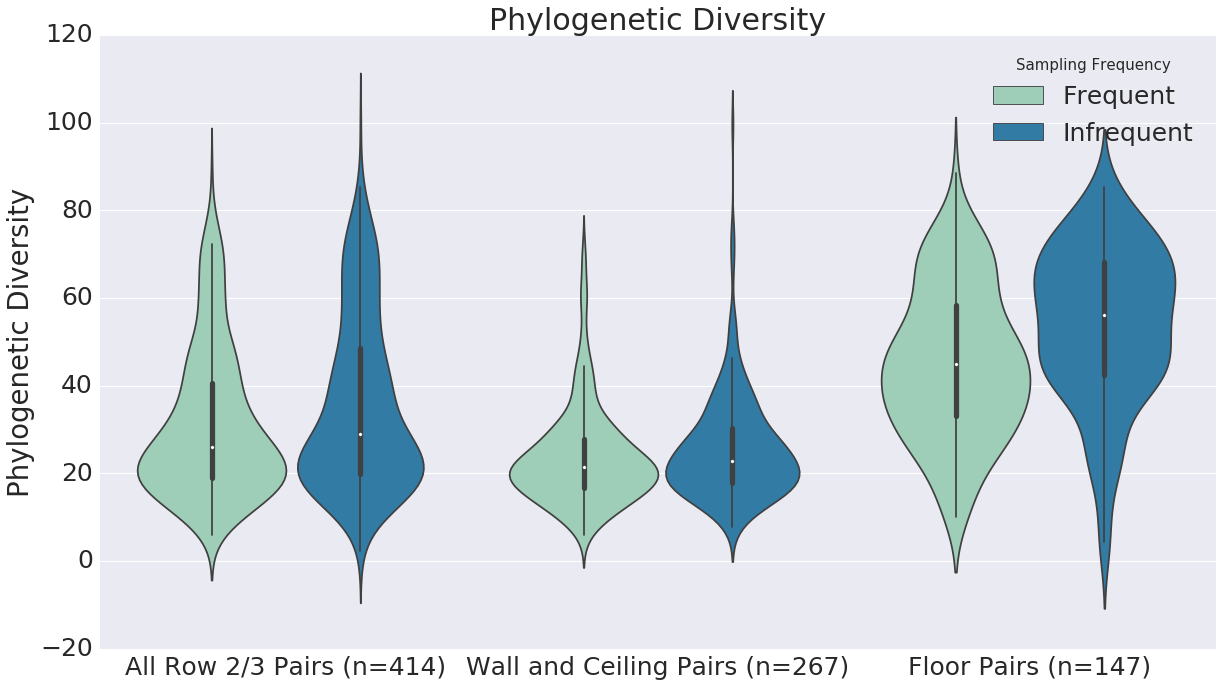

In [33]:
with plt.rc_context(dict(sns.axes_style("darkgrid"),
                         **sns.plotting_context("notebook", font_scale=2.5))):
    plt.figure(figsize=(20, 11))

    ax = sns.violinplot(x='SampleType', y='MeanAlpha', data=plot_df, hue='Row',hue_order=['3', '2'], 
                        palette="YlGnBu")
    ax.set_xlabel('')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, ['Frequent', 'Infrequent'], title='Sampling Frequency')
    ax.set_ylabel('Phylogenetic Diversity')
    ax.set_title('Phylogenetic Diversity')
    ax.get_legend().get_title().set_fontsize('15')
    plt.savefig('figure-3-A.svg', dpi=300)

In [34]:
row_2_values = list(row_df[(row_df['Row'] == '2')]['MeanAlpha'])
row_3_values = list(row_df[(row_df['Row'] == '3')]['MeanAlpha'])
obs_t, param_p_val, perm_t_stats, nonparam_p_val = mc_t_two_sample(row_2_values, row_3_values)
obs_t, param_p_val

(3.4050074439833375, 0.00069353227018487118)

In [14]:
row_2_values = list(sample_md_wall[(sample_md_wall['Row'] == '2')]['MeanAlpha'])
row_3_values = list(sample_md_wall[(sample_md_wall['Row'] == '3')]['MeanAlpha'])
obs_t, param_p_val, perm_t_stats, nonparam_p_val = mc_t_two_sample(row_2_values, row_3_values)
obs_t, param_p_val

(1.9273105882573822, 0.05447305999111185)

In [15]:
row_2_values = list(sample_md_floor[(sample_md_floor['Row'] == '2')]['MeanAlpha'])
row_3_values = list(sample_md_floor[(sample_md_floor['Row'] == '3')]['MeanAlpha'])
obs_t, param_p_val, perm_t_stats, nonparam_p_val = mc_t_two_sample(row_2_values, row_3_values)
obs_t, param_p_val

(4.3412234578119895, 1.9557378364121192e-05)

Beta Diversity
-------------

Create beta diversity boxplots of within and bewteen distances for row. It may not make a lot of sense doing this for all samples as the location and or city affect may drown out the row affect

Load the distance matrix
----------------------

The code can be run for each distance matrix

In [16]:
dm = skbio.DistanceMatrix.read('/home/office-microbe-files/core_div_out/bdiv_even1000/weighted_unifrac_dm.txt')

Run permanova and recored within between values on various categories
----------------------

All of these will be based on the row 2, 3 paired samples, though they may be filtered to avoind confounding variables

###Row distances

In [17]:
filt_map = row_df[(row_df['City'] == 'flagstaff') & (row_df['Run'] == '2')]
filt_dm, filt_map = filter_dm_and_map(dm, filt_map)

row_dists = get_within_between_distances(filt_map, filt_dm, 'Row')
row_dists['Category'] = 'Row (n=198)'

permanova(filt_dm, filt_map, column='Row', permutations=999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     198
number of groups                  2
test statistic              1.64401
p-value                       0.103
number of permutations          999
Name: PERMANOVA results, dtype: object

###Plate location

We can use the same samples for this as the previous test

In [18]:
plate_dists = get_within_between_distances(filt_map, filt_dm, 'PlateLocation')
plate_dists['Category'] = 'Plate Location (n=198)'

permanova(filt_dm, filt_map, column='PlateLocation', permutations=999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     198
number of groups                  3
test statistic              22.8805
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

###Run

In [19]:
filt_map = row_df[(row_df['City'] == 'flagstaff')]
filt_dm, filt_map = filter_dm_and_map(dm, filt_map)
run_dists = get_within_between_distances(filt_map, filt_dm, 'Run')
run_dists['Category'] = 'Run (n=357)'
permanova(filt_dm, filt_map, column='Run', permutations=999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     358
number of groups                  3
test statistic              47.6552
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

###Material

In [20]:
filt_map = row_df[(row_df['City'] == 'flagstaff') & (row_df['Run'] == '2')]
filt_dm, filt_map = filter_dm_and_map(dm, filt_map)

material_dists = get_within_between_distances(filt_map, filt_dm, 'Material')
material_dists['Category'] = 'Material (n=198)'

permanova(filt_dm, filt_map, column='Material', permutations=999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     198
number of groups                  3
test statistic              1.16195
p-value                        0.27
number of permutations          999
Name: PERMANOVA results, dtype: object

In [21]:
all_dists = material_dists.append(row_dists).append(plate_dists).append(run_dists)

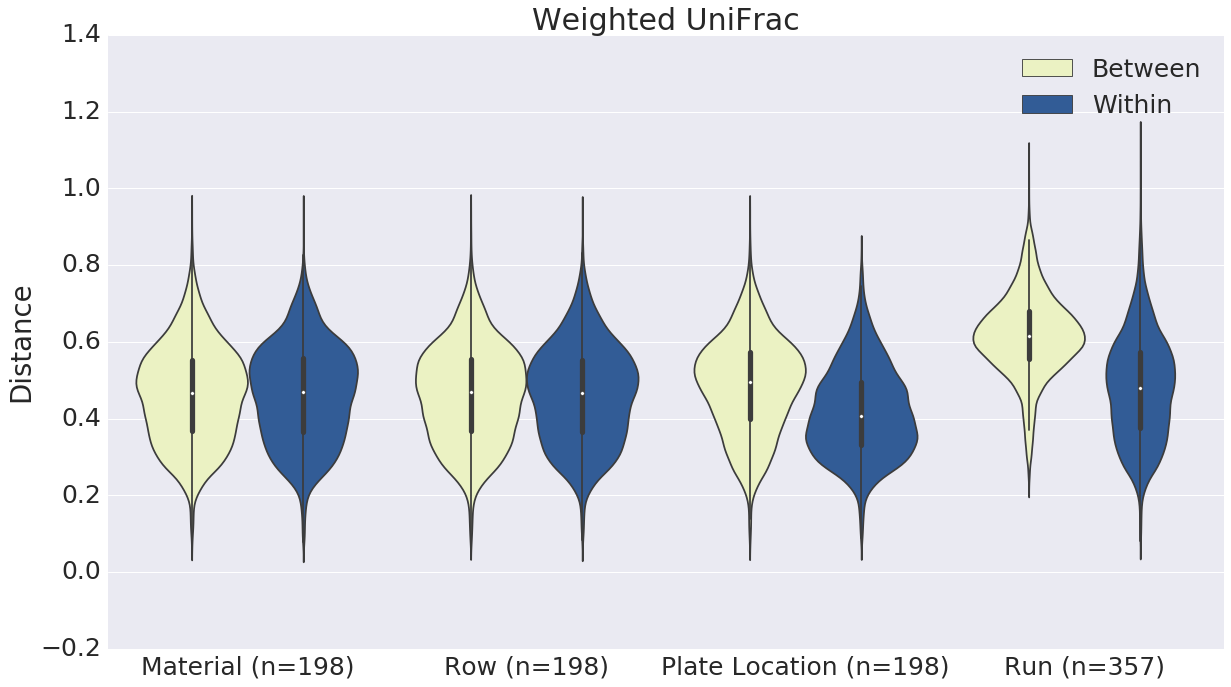

In [22]:
with plt.rc_context(dict(sns.axes_style("darkgrid"),
                         **sns.plotting_context("notebook", font_scale=2.5))):
    plt.figure(figsize=(20,11))
    ax = sns.violinplot(x="Category", y="Distance", hue="Groups", data=all_dists, palette=sns.color_palette(['#f1fabb', '#2259a6']))
    ax.set_title('Weighted UniFrac')
    ax.set_xlabel('')
    plt.legend(loc='upper right')
    plt.savefig('figure-3-B.svg', dpi=300)
    

In [23]:
dm = skbio.DistanceMatrix.read('/home/office-microbe-files/core_div_out/bdiv_even1000/unweighted_unifrac_dm.txt')

In [24]:
filt_map = row_df[(row_df['City'] == 'flagstaff') & (row_df['Run'] == '2')]
filt_dm, filt_map = filter_dm_and_map(dm, filt_map)

row_dists = get_within_between_distances(filt_map, filt_dm, 'Row')
row_dists['Category'] = 'Row (n=198)'

permanova(filt_dm, filt_map, column='Row', permutations=999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     198
number of groups                  2
test statistic              1.12793
p-value                       0.181
number of permutations          999
Name: PERMANOVA results, dtype: object

##Row Distances

In [25]:
filt_map = row_df[(row_df['City'] == 'flagstaff') & (row_df['Run'] == '2')]
filt_dm, filt_map = filter_dm_and_map(dm, filt_map)

row_dists = get_within_between_distances(filt_map, filt_dm, 'Row')
row_dists['Category'] = 'Row (n=198)'

permanova(filt_dm, filt_map, column='Row', permutations=999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     198
number of groups                  2
test statistic              1.12793
p-value                       0.176
number of permutations          999
Name: PERMANOVA results, dtype: object

###Plate location

We can use the same samples for this as the previous test

In [26]:
plate_dists = get_within_between_distances(filt_map, filt_dm, 'PlateLocation')
plate_dists['Category'] = 'Plate Location (n=198)'

permanova(filt_dm, filt_map, column='PlateLocation', permutations=999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     198
number of groups                  3
test statistic              9.35979
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

##Run

In [27]:
filt_map = row_df[(row_df['City'] == 'flagstaff')]
filt_dm, filt_map = filter_dm_and_map(dm, filt_map)
run_dists = get_within_between_distances(filt_map, filt_dm, 'Run')
run_dists['Category'] = 'Run (n=357)'
permanova(filt_dm, filt_map, column='Run', permutations=999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     358
number of groups                  3
test statistic              15.7625
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

##Material

In [28]:
filt_map = row_df[(row_df['City'] == 'flagstaff') & (row_df['Run'] == '2')]
filt_dm, filt_map = filter_dm_and_map(dm, filt_map)

material_dists = get_within_between_distances(filt_map, filt_dm, 'Material')
material_dists['Category'] = 'Material (n=198)'

permanova(filt_dm, filt_map, column='Material', permutations=999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     198
number of groups                  3
test statistic              1.23746
p-value                       0.054
number of permutations          999
Name: PERMANOVA results, dtype: object

In [29]:
all_dists = material_dists.append(row_dists).append(plate_dists).append(run_dists)

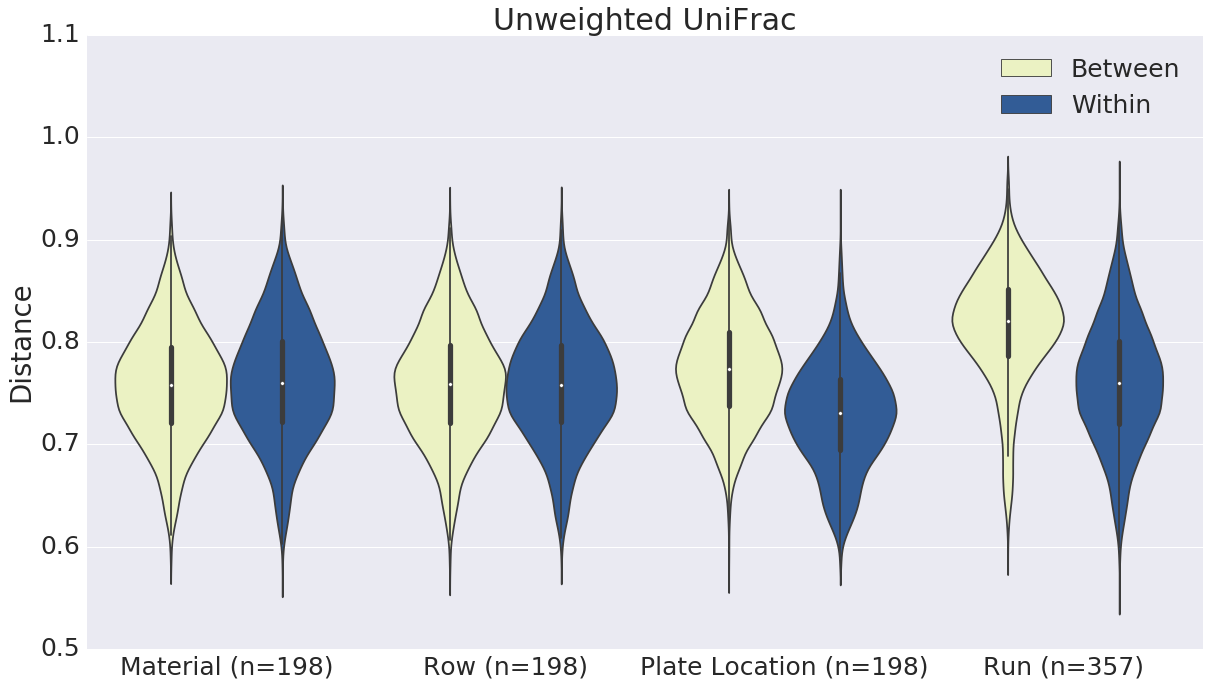

In [30]:
with plt.rc_context(dict(sns.axes_style("darkgrid"),
                         **sns.plotting_context("notebook", font_scale=2.5))):
    plt.figure(figsize=(20,11))
    ax = sns.violinplot(x="Category", y="Distance", hue="Groups", data=all_dists, palette=sns.color_palette(['#f1fabb', '#2259a6']))
    ax.set_title('Unweighted UniFrac')
    ax.set_xlabel('')
    plt.legend(loc='upper right')
    plt.savefig('figure-3-C.svg', dpi=300)

ANCOM
-----

In [11]:
pd.options.display.max_colwidth = 200

In [12]:
table_fp = join(home, 'core_div_out/table_even1000.txt')
table = pd.read_csv(table_fp, sep='\t', skiprows=1, index_col=0).T
table.index = table.index.astype(str)
table.columns = table.columns.astype(str)

/home/johnchase/.conda/envs/da/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
table_ancom = table.loc[:, table.sum(axis=0) > 100]

In [35]:
filt_map = row_df[(row_df['City'] == 'flagstaff') & (row_df['Run'] == '2')]

In [36]:
table_ancom = pd.DataFrame(multiplicative_replacement(table_ancom), index=table_ancom.index, columns=table_ancom.columns)
table_ancom.dropna(axis=0, inplace=True)
intersect_ids = set(filt_map.index).intersection(set(table_ancom.index))
row_md_ancom = filt_map.loc[intersect_ids, ]
table_ancom = table_ancom.loc[intersect_ids, ]

In [37]:
%%time
results = ancom(table_ancom, row_md_ancom['PlateLocation'])

CPU times: user 2min 9s, sys: 222 ms, total: 2min 10s
Wall time: 2min 9s


In [38]:
sigs = results[results['reject'] == True]

In [39]:
tax_fp = '/home/office-microbe-files/pick_otus_out_97/uclust_assigned_taxonomy/rep_set_tax_assignments.txt'
taxa_map = pd.read_csv(tax_fp, sep='\t', index_col=0, names=['Taxa', 'none', 'none'])
taxa_map.drop('none', axis=1, inplace=True)
taxa_map.index = taxa_map.index.astype(str)

In [40]:
top_ten = taxa_map.loc[sigs.sort_values('W').index.astype(str)][:10]
top_ten.index = top_ten.index.astype(str)

In [46]:
top_ten.sort_values('Taxa')

,Taxa
#OTU ID,
305430,k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Intrasporangiaceae; g__; s__
1017181,k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Micrococcaceae; g__Rothia; s__mucilaginosa
248831,k__Bacteria; p__Bacteroidetes; c__Cytophagia; o__Cytophagales; f__Cytophagaceae; g__Hymenobacter; s__
912669,k__Bacteria; p__Bacteroidetes; c__[Saprospirae]; o__[Saprospirales]; f__Chitinophagaceae; g__; s__
New.1.ReferenceOTU1987,k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Lactobacillaceae; g__Lactobacillus; s__
582379,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Clostridiaceae
798097,k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhizobiales; f__Hyphomicrobiaceae; g__Devosia; s__
345540,k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__; s__
988314,k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales; f__Moraxellaceae; g__Acinetobacter; s__


In [47]:
table_OTUs = table[top_ten.index].copy()/1000
table_OTUs['PlateLocation'] = sample_md.loc[table_OTUs.index.tolist(), 'PlateLocation']
table_counts = table_OTUs.groupby('PlateLocation').describe().unstack().T
table_counts.reset_index(inplace=True)
table_counts = table_counts[table_counts['level_1'].isin(['mean', 'std'])]
table_counts = table_counts.reset_index().set_index('#OTU ID')
table_counts['Taxa'] = taxa_map.loc[table_counts.index, 'Taxa']
table_counts = table_counts.set_index(['Taxa', 'level_1'])
table_counts.drop('index', axis=1, inplace=True)

In [70]:
table_ancom.loc[row_md_ancom[row_md_ancom.PlateLocation == 'wall'].index, '1017181'].sum()

0.037328360118380671

In [52]:
table_counts


PlateLocation                                                                                                                  ceiling  \
Taxa                                                                                                                 level_1             
k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Micrococcaceae; g__Rothia; s__mucilaginosa mean     0.000846   
                                                                                                                     std      0.014962   
k__Bacteria; p__Bacteroidetes; c__Cytophagia; o__Cytophagales; f__Cytophagaceae; g__Hymenobacter; s__                mean     0.000002   
                                                                                                                     std      0.000042   
k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Intrasporangiaceae; g__; s__               mean     0.000113   
                                                                                                                     std      0.002179   
k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__; s__        mean     0.000917   
                                                                                                                     std      0.004577   
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Clostridiaceae                                       mean     0.000064   
                                                                                                                     std      0.000767   
k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhizobiales; f__Hyphomicrobiaceae; g__Devosia; s__        mean     0.000029   
                                                                                                                     std      0.000388   
k__Bacteria; p__Bacteroidetes; c__[Saprospirae]; o__[Saprospirales]; f__Chitinophagaceae; g__; s__                   mean     0.000009   
                                                                                                                     std      0.000138   
k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales; f__Moraxellaceae; g__Acinetobacter; s__  mean     0.000104   
                                                                                                                     std      0.000433   
                                                                                                                     mean     0.023374   
                                                                                                                     std      0.030753   
k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Lactobacillaceae; g__Lactobacillus; s__               mean     0.000087   
                                                                                                                     std      0.000520   

PlateLocation                                                                                                                    floor  \
Taxa                                                                                                                 level_1             
k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Micrococcaceae; g__Rothia; s__mucilaginosa mean     0.000481   
                                                                                                                     std      0.001595   
k__Bacteria; p__Bacteroidetes; c__Cytophagia; o__Cytophagales; f__Cytophagaceae; g__Hymenobacter; s__                mean     0.000142   
                                                                                                                     std      0.000601   
k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Intrasporangiaceae; g__; s__               mean     0.000281 

In [42]:
df_final = pd.DataFrame(columns=['Ceiling', 'Floor', 'Wall'])
for i in table_counts.index.get_level_values(level=0):
        df_final.loc[i, ['Ceiling', 'Floor', 'Wall']] = ['{0:.{digits}f} +/- {1:.{digits}f}'.format(mean, std, digits=6) for mean, std in zip(table_counts.loc[i, 'mean'].values[0], table_counts.loc[i, 'std'].values[0])]

/home/johnchase/.conda/envs/da/lib/python3.5/site-packages/IPython/kernel/__main__.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  app.launch_new_instance()


In [43]:
df_final

,Ceiling,Floor,Wall
k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Micrococcaceae; g__Rothia; s__mucilaginosa,0.000846 +/- 0.014962,0.000481 +/- 0.001595,0.000430 +/- 0.002293
k__Bacteria; p__Bacteroidetes; c__Cytophagia; o__Cytophagales; f__Cytophagaceae; g__Hymenobacter; s__,0.000002 +/- 0.000042,0.000142 +/- 0.000601,0.000048 +/- 0.000778
k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Intrasporangiaceae; g__; s__,0.000113 +/- 0.002179,0.000281 +/- 0.000866,0.000084 +/- 0.000850
k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__; s__,0.000917 +/- 0.004577,0.000674 +/- 0.002137,0.000861 +/- 0.003254
k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Clostridiaceae,0.000064 +/- 0.000767,0.000378 +/- 0.002654,0.000319 +/- 0.004288
k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhizobiales; f__Hyphomicrobiaceae; g__Devosia; s__,0.000029 +/- 0.000388,0.000326 +/- 0.001285,0.000119 +/- 0.000920
k__Bacteria; p__Bacteroidetes; c__[Saprospirae]; o__[Saprospirales]; f__Chitinophagaceae; g__; s__,0.000009 +/- 0.000138,0.000300 +/- 0.001099,0.000051 +/- 0.000597
k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales; f__Moraxellaceae; g__Acinetobacter; s__,0.000104 +/- 0.000433,0.000074 +/- 0.000693,0.000086 +/- 0.000398
k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Lactobacillaceae; g__Lactobacillus; s__,0.000087 +/- 0.000520,0.000037 +/- 0.000307,0.000102 +/- 0.000633


In [44]:
table_fp = join(home, 'core_div_out/table_even1000.txt')
table = pd.read_csv(table_fp, sep='\t', skiprows=1, index_col=0).T
table.index = table.index.astype(str)
table.columns = table.columns.astype(str)

/home/johnchase/.conda/envs/da/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [45]:
table_ancom = table.loc[:, table.sum(axis=0) > 100]
table_ancom = pd.DataFrame(multiplicative_replacement(table_ancom), index=table_ancom.index, columns=table_ancom.columns)
table_ancom.dropna(axis=0, inplace=True)
intersect_ids = set(row_df.index).intersection(set(table_ancom.index))
row_md_ancom = row_df.loc[intersect_ids, ]
table_ancom = table_ancom.loc[intersect_ids, ]

In [46]:
%%time
results = ancom(table_ancom, row_md_ancom['Row'])

CPU times: user 1min 55s, sys: 35.8 ms, total: 1min 55s
Wall time: 1min 55s


In [47]:
sigs = results[results['reject'] == True]

In [48]:
top_ten = taxa_map.loc[sigs.sort_values('W').index.astype(str)][:10]
top_ten.index = top_ten.index.astype(str)

In [49]:
table_OTUs = table[top_ten.index].copy()/1000
table_OTUs['Row'] = sample_md.loc[table_OTUs.index.tolist(), 'Row']
table_counts = table_OTUs.groupby('Row').describe().unstack().T
table_counts.reset_index(inplace=True)
table_counts = table_counts[table_counts['level_1'].isin(['mean', 'std'])]
table_counts = table_counts.reset_index().set_index('#OTU ID')
table_counts['Taxa'] = taxa_map.loc[table_counts.index, 'Taxa']
table_counts = table_counts.set_index(['Taxa', 'level_1'])
table_counts.drop('index', axis=1, inplace=True)

In [50]:
cols = ['Row 1', 'Row 2']
df_final = pd.DataFrame(columns=cols)
for i in table_counts.index.get_level_values(level=0):
        df_final.loc[i, cols] = ['{0:.{digits}f} +/- {1:.{digits}f}'.format(mean, std, digits=6) for mean, std in zip(table_counts.loc[i, 'mean'].values[0], table_counts.loc[i, 'std'].values[0])]

/home/johnchase/.conda/envs/da/lib/python3.5/site-packages/IPython/kernel/__main__.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.


In [51]:
df_final

,Row 1,Row 2
k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Microbacteriaceae; g__; s__,0.002015 +/- 0.004263,0.001021 +/- 0.002746
k__Bacteria; p__Proteobacteria; c__Betaproteobacteria; o__Burkholderiales; f__Comamonadaceae; g__; s__,0.000873 +/- 0.007994,0.002153 +/- 0.010556
k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Sphingomonadales; f__Sphingomonadaceae; g__Sphingomonas,0.001256 +/- 0.003744,0.000805 +/- 0.002726
k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales; f__Moraxellaceae; g__Acinetobacter,0.001183 +/- 0.006361,0.000720 +/- 0.004126
k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Vibrionales; f__Pseudoalteromonadaceae; g__Pseudoalteromonas; s__,0.000086 +/- 0.000356,0.000074 +/- 0.000304
k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Pseudomonadales; f__Pseudomonadaceae; g__; s__,0.000343 +/- 0.000853,0.000267 +/- 0.000726
k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Actinomycetales; f__Corynebacteriaceae; g__Corynebacterium; s__,0.001483 +/- 0.003612,0.001438 +/- 0.006215
k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Sphingomonadales; f__Sphingomonadaceae; g__Sphingomonas; s__,0.002808 +/- 0.010694,0.001904 +/- 0.012363
k__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Sphingomonadales; f__Sphingomonadaceae; g__Kaistobacter; s__,0.000655 +/- 0.001646,0.000372 +/- 0.001530
